In [ ]:
from transformers import AutoTokenizer
model_name = "google-t5/t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
print(f"Type: {type(tokenizer)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Type: <class 'transformers.models.t5.tokenization_t5_fast.T5TokenizerFast'>


In [ ]:
sentence = "hello, this is a sentence!"
tokens = tokenizer(sentence)
print(tokens)

{'input_ids': [21820, 6, 48, 19, 3, 9, 7142, 55, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [ ]:
tokenizer.decode(tokens["input_ids"])

'hello, this is a sentence!</s>'

In [ ]:
import random
vocabulary = tokenizer.get_vocab()
reverse_vocab = {v: k for k, v in vocabulary.items()}
vocab_keys = list(vocabulary.keys())
random.shuffle(vocab_keys)
{k : vocabulary[k] for k in vocab_keys[:10]}

{'▁criz': 21798,
 '▁komplexe': 26973,
 'litz': 13668,
 'modalité': 29707,
 'practic': 22255,
 '▁Hunter': 14046,
 'smallest': 17924,
 'Char': 18947,
 '▁claims': 3213,
 '▁celebrate': 4036}

In [ ]:
print("Total vocabulary size:", len(vocabulary))

Total vocabulary size: 32100


In [ ]:
vocabulary["</s>"]

1

In [ ]:
tokens["input_ids"]

[21820, 6, 48, 19, 3, 9, 7142, 55, 1]

In [ ]:
tokenizer("hello!</s></s>")

{'input_ids': [21820, 55, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1]}

In [ ]:
print(tokenizer.tokenize("hello ,world"))
print(tokenizer.tokenize("hello , world"))

['▁hello', '▁', ',', 'world']
['▁hello', '▁', ',', '▁world']


### Special tokens

Each model typically has its own special tokens. Some are necessary for the training process, while others can be beneficial at inference time.

Special attributes are available in the tokenizer class to access these special tokens. Some examples are:

- `pad_token` is the token used for padding (as discussed later),
- `bos_token` and `eos_token` tokens are used to indicate the beginning and end of the input text, respectively,
- `mask_token` is used for masking tokens during training (e.g., for the masked LM task, with BERT),
- `sep_token` is used to separate sentences in the input text (e.g., next sentence prediction, with BERT),
- `cls_token` is used to indicate the beginning of the input text (e.g., for classification tasks, with BERT),
- `unk_token` is used to indicate unknown tokens (i.e., tokens that are not in the vocabulary).

Of course, not all tokenizers will use all tokens. So those attributes will be set to None, if not used.

For instance, T5 has EOS and PAD tokens, but no BOS token.

In [ ]:
tokenizer.eos_token, tokenizer.pad_token, tokenizer.bos_token

('</s>', '<pad>', None)

The `_id` suffix is used to indicate the corresponding token ID (None if not applicable).

In [ ]:
tokenizer.eos_token_id, tokenizer.pad_token_id, tokenizer.bos_token_id

(1, 0, None)

### Batch encoding/decoding

In general (especially at training time) we will want to encode multiple sentences at once (e.g., an entire batch of sentences).

We can pass a list of sentences to be encoded to the tokenizer.

In [ ]:
sentences = [
    "this is the first sentence",
    "instead, this is the second sequence!"
]
tokens = tokenizer(sentences)
tokens

{'input_ids': [[48, 19, 8, 166, 7142, 1], [1446, 6, 48, 19, 8, 511, 5932, 55, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}

Of course, sentences of different lengths have a different number of tokens! However, tensors (that will be used by the model) need to have the same number of elements along each dimension.

To do this, we can use padding: all sentences will be padded to the length of the longest sentence in the batch. This is done by adding `pad` tokens (`<pad>`, for T5).

However, since the pad tokens are not part of the input text, we need to let the model know that it should not pay attention to them. That's what the `attention_mask` is for!

In [ ]:
tokens = tokenizer(sentences, padding=True)
tokens

{'input_ids': [[48, 19, 8, 166, 7142, 1, 0, 0, 0], [1446, 6, 48, 19, 8, 511, 5932, 55, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1]]}

The first sentence is padded to the same length as the second sentence, with 0's (remember, the ID for `<pad>`!).

The attention mask for the first sentence also contains 0's for the padding tokens: the model will ignore them when processing the input text.

Since now all sentences have the same length, we can stack them into a single tensor. Luckily, the tokenizer can already do this for us, we just need to ask.


In [ ]:
tokens = tokenizer(sentences, padding=True, return_tensors="pt")
print(tokens["input_ids"])
print(tokens["attention_mask"])

tensor([[  48,   19,    8,  166, 7142,    1,    0,    0,    0],
        [1446,    6,   48,   19,    8,  511, 5932,   55,    1]])
tensor([[1, 1, 1, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 1, 1, 1, 1, 1]])


For completeness, we can also decode batches of sentences, with `tokenizer.batch_decode()`.

In [ ]:
tokenizer.batch_decode(tokens["input_ids"])

['this is the first sentence</s><pad><pad><pad>',
 'instead, this is the second sequence!</s>']

## Model analysis

Now we can go ahead and finally load our T5 model. We once again use a pretrained version available on HuggingFace.

In general, we could use the `AutoModel` class for the loading, of the model. However, that version of the model does not include the specific heads for the tasks that T5 was trained on.

The transformers library can make our life easier by defining a family of `AutoModel...` classes.

For instance, the following are some commonly adopted classes:
- `AutoModel`: the base class for all models,
- `AutoModelForSequenceClassification`: a model for sequence classification tasks. It consists of a base model plus a classification head (linear layer + softmax). Note that, generally, the classification head is initialized randomly, and it needs to be trained on the specific task (but the library will let you know with a warning),
- `AutoModelForCaualLM`: a model for causal language modeling tasks (e.g., GPT-2), where we generate the output tokens one by one,
- `AutoModelForMaskedLM`: a model for masked language modeling tasks (e.g., BERT), where we predict the masked tokens in the input text,
- `AutoModelForTokenClassification`: a model for token classification tasks (e.g., NER), where we classify each token in the input text.
- `AutoModelForSeq2SeqLM`: a model for sequence-to-sequence tasks (e.g., T5), where we generate the output tokens one by one in an autoregressive manner, conditioned on the input sequence.

In our specific case, we will use the `AutoModelForSeq2SeqLM` class to be able to generate new tokens.

In [ ]:
from transformers import AutoModelForSeq2SeqLM

model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

print(f"Type of the model: {type(model)}")

model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Type of the model: <class 'transformers.models.t5.modeling_t5.T5ForConditionalGeneration'>


To better understand the model, we can take a look at the model's configuration. The configuration contains all the hyperparameters of the model. The configuration is available as a dictionary, and we can access the values by using the attribute notation.

You can find the model's configuration object in the `config` attribute of the model. Or, if you only need the configuration, you can directly load it using the `AutoConfig` class.

```python
from transformers import AutoConfig

config = AutoConfig.from_pretrained(model_name)
```

In [ ]:
model.config

T5Config {
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "classifier_dropout": 0.0,
  "d_ff": 3072,
  "d_kv": 64,
  "d_model": 768,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "dtype": "float32",
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_epsilon": 1e-06,
  "model_type": "t5",
  "n_positions": 512,
  "num_decoder_layers": 12,
  "num_heads": 12,
  "num_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "relative_attention_max_distance": 128,
  "relative_attention_num_buckets": 32,
  "task_specific_params": {
    "summarization": {
      "early_stopping": true,
      "length_penalty": 2.0,
      "max_length": 200,
      "min_length": 30,
      "no_repeat_ngram_size": 3,
      "num_beams": 4,
      "prefix": "summarize: "
    },
    "translation_en_to_de": {
      "early_stopping": true,
      "max_length": 300,
      "num_

Lots of information going on here. We can just take a few key aspects:

- `d_kv` = 64. This is the dimension of keys $d_k$ (so also queries) and values $d_v$ in the attention mechanism. It is common, to keep things simple, to use the same number of dimensions for keys, queries, and values (even though this is not strictly necessary).
- `d_model` = 768. This is the dimension of the output of each transformer block.
- `d_ff` = 3072. This is the dimension of the feedforward network in each transformer block. We will see that the feedforward network is composed of two linear layers with a ReLU activation in between (`d_model -> d_ff -> d_model`).
- `num_layers` = 12. This is the number of transformer blocks in the model (both encoder and decoder).
- `num_heads` = 12. This is the number of attention heads in the multi-head attention mechanism. Each head will produce a different representation of the input text, and the results will be concatenated together. Remember that the output of each attention head is concatenated. We have 12 heads, each producing a 64-dimensional output, so the final output will be 12 * 64 = 768-dimensional.

In [ ]:
model

T5ForConditionalGeneration(
  (shared): Embedding(32128, 768)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 768)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=768, out_features=768, bias=False)
              (k): Linear(in_features=768, out_features=768, bias=False)
              (v): Linear(in_features=768, out_features=768, bias=False)
              (o): Linear(in_features=768, out_features=768, bias=False)
              (relative_attention_bias): Embedding(32, 12)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=768, out_features=3072, bias=False)
              (wo): Linear(in_features=3072, out_features=768, bias=False)
              (dropout): Dro

We see that the model has a `shared` Embedding layer, an `encoder` and a `decoder`, and a final `lm_head`.

We can look into the token embedding first.


### Tokens embedding


In [ ]:
model.shared

Embedding(32128, 768)

First, we can verify that this `shared` embedding layer, as the name suggests, is shared between the encoder and the decoder.

We do so by checking the id of the embedding layer with the embedding layers found in the encoder and decoder (`model.encoder.embed_tokens` and `model.decoder.embed_tokens`).

In [ ]:
id(model.shared) == id(model.encoder.embed_tokens) and id(model.shared) == id(model.decoder.embed_tokens)

True

Next, we note that the embedding layer has 32128 tokens.

This is not exactly the number of tokens we saw before (32100). The extra 28 tokens are "leftovers". 32128 = 251 * 128 is a more "GPU friendly" number, and it's used to speed up the computation (same reason why we often see batch sizes that are powers of 2).

In [ ]:
words = [
    "chair",
    "table",
    "plate",
    "knife",
    "spoon",
    "horse",
    "goat",
    "sheep",
    "cat",
    "dog",
]

In [ ]:
words_token = tokenizer(words, return_tensors="pt", padding=True)["input_ids"][:,0]
print(words_token)
token_embeddings = model.shared(words_token).cpu().detach().numpy()
print(token_embeddings.shape)

tensor([ 3533,   953,  3829, 10821, 14987,  4952, 18174, 15184,  1712,  1782])
(10, 768)


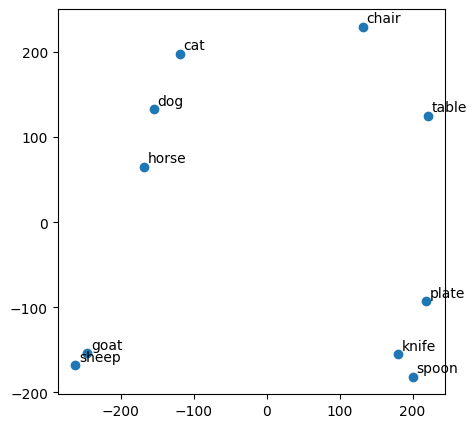

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X_pca = pca.fit_transform(token_embeddings)

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(X_pca[:,0], X_pca[:,1])
for i,word in enumerate(words):
    ax.text(X_pca[i,0]+5, X_pca[i,1]+5, word)

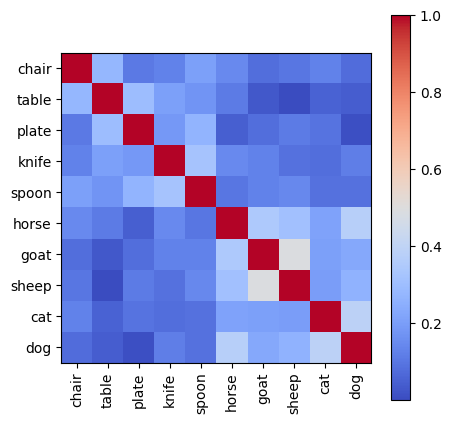

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_similarity(token_embeddings)
fig, ax = plt.subplots(figsize=(5,5))
cax = ax.imshow(cosine_similarity(token_embeddings), cmap="coolwarm")
fig.colorbar(cax)
plt.xticks(range(len(words)), words, rotation=90)
plt.yticks(range(len(words)), words);

### Encoder


The model's encoder contains various transformer layers (each one attention, feed-forward, and normalization layers).

In [ ]:
model.encoder

T5Stack(
  (embed_tokens): Embedding(32128, 768)
  (block): ModuleList(
    (0): T5Block(
      (layer): ModuleList(
        (0): T5LayerSelfAttention(
          (SelfAttention): T5Attention(
            (q): Linear(in_features=768, out_features=768, bias=False)
            (k): Linear(in_features=768, out_features=768, bias=False)
            (v): Linear(in_features=768, out_features=768, bias=False)
            (o): Linear(in_features=768, out_features=768, bias=False)
            (relative_attention_bias): Embedding(32, 12)
          )
          (layer_norm): T5LayerNorm()
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (1): T5LayerFF(
          (DenseReluDense): T5DenseActDense(
            (wi): Linear(in_features=768, out_features=3072, bias=False)
            (wo): Linear(in_features=3072, out_features=768, bias=False)
            (dropout): Dropout(p=0.1, inplace=False)
            (act): ReLU()
          )
          (layer_norm): T5LayerNorm()
          (d

The `block` attribute is a list of `T5Block` modules, and contains the actual transformer layers. Indeed, we can check (as previously stated) that we have 12 encoder layers in the encoder.

In [ ]:
len(model.encoder.block)

12

Each of the modules inside of the `block` is composed of a `T5LayerSelfAttention` module (attention layer), followed by a `T5LayerFF` module (feed-forward layer).

Remember that there are some other details (e.g., normalization layers, or dropouts) that are shown below, but we will not discuss them in detail here.


In [ ]:
model.encoder.block[0]

T5Block(
  (layer): ModuleList(
    (0): T5LayerSelfAttention(
      (SelfAttention): T5Attention(
        (q): Linear(in_features=768, out_features=768, bias=False)
        (k): Linear(in_features=768, out_features=768, bias=False)
        (v): Linear(in_features=768, out_features=768, bias=False)
        (o): Linear(in_features=768, out_features=768, bias=False)
        (relative_attention_bias): Embedding(32, 12)
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): T5LayerFF(
      (DenseReluDense): T5DenseActDense(
        (wi): Linear(in_features=768, out_features=3072, bias=False)
        (wo): Linear(in_features=3072, out_features=768, bias=False)
        (dropout): Dropout(p=0.1, inplace=False)
        (act): ReLU()
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
  )
)

Notice that the $W_q$, $W_k$, and $W_v$ matrices are 768x768. But, we stated that each attention is 64-dimensional, so they should be 768x64!

However, remember that we have 12 heads: instead of producing 12 different heads, we instead efficiently represent all matrices inside of a single matrix. In addition, there is no need for concatenating the results: the output will already be the concatenation of all heads.

The $W_o$ matrix is 768x768, i.e. `d_kv`*`num_heads` x `d_model`, as expected.

### Decoder

We can inspect the decoder in the same way.

In [ ]:
model.decoder.block[0]

T5Block(
  (layer): ModuleList(
    (0): T5LayerSelfAttention(
      (SelfAttention): T5Attention(
        (q): Linear(in_features=768, out_features=768, bias=False)
        (k): Linear(in_features=768, out_features=768, bias=False)
        (v): Linear(in_features=768, out_features=768, bias=False)
        (o): Linear(in_features=768, out_features=768, bias=False)
        (relative_attention_bias): Embedding(32, 12)
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): T5LayerCrossAttention(
      (EncDecAttention): T5Attention(
        (q): Linear(in_features=768, out_features=768, bias=False)
        (k): Linear(in_features=768, out_features=768, bias=False)
        (v): Linear(in_features=768, out_features=768, bias=False)
        (o): Linear(in_features=768, out_features=768, bias=False)
      )
      (layer_norm): T5LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): T5LayerFF(
      (DenseReluDense): T5DenseA

Indeed, we find the expected architecture.

An initial self-attention module, followed by a multi-head attention one (`T5LayerCrossAttention`), and finally a feed-forward module.

Note that, although there is a dedicated class for cross-attention, the module still makes use of the same `T5Attention` class we also used for self-attention. This is because nothing changes in the attention mechanism itself: only the inputs are different.

Finally, note that the model's `lm_head` is a linear layer that takes the output of the decoder (768-dimensional) and maps it to the vocabulary size (32128).

In [ ]:
model.lm_head

Linear(in_features=768, out_features=32128, bias=False)

## Token generation

Let's now focus on the token generation process.

Remember, we are working with an encoder-decoder architecture. The encoder processes the input text, and the decoder generates the output text.

The input for the encoder is the tokenized input text. We also need to specify an input for the decoder. The decoder's input will be the currently generated sequence thus far. For the first iteration, there is nothing already generated, so we need to specify a special token to indicate the beginning of the sequence (BOS). For T5, the token will be `<pad_token>`.

In [ ]:
import torch
input_sentence = "translate english to german: hello, how are you?"
tokens = tokenizer(input_sentence, return_tensors="pt")
decoder_input_ids = torch.tensor([[tokenizer.pad_token_type_id]])

In [ ]:
print("Encoder's input")
print(tokens["input_ids"])

print()
print("Decoder's input")
print(decoder_input_ids)

Encoder's input
tensor([[13959, 22269,    12, 13692,    10, 21820,     6,   149,    33,    25,
            58,     1]])

Decoder's input
tensor([[0]])
